In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class read_eplusql:
    def __init__(self,file,read="all",):
        
        self.myconn = sql.connect(file)
        if (read=="data") or (read=="all"):
            command = "SELECT ReportDataDictionaryIndex, KeyValue, Name, Units FROM ReportDataDictionary"
            variables = pd.read_sql_query(command,con=self.myconn)

            variables['variable_name'] = variables.KeyValue + ':' + variables.Name + ' (' + variables.Units + ')'
            self.variables = variables
            self.vars = variables.variable_name.unique()

            command = "SELECT tm.TimeIndex, tm.Year, tm.Month, tm.Day, tm.Hour, tm.Minute FROM Time AS tm"
            time = pd.read_sql_query(command,con=self.myconn)
            time = time[time.Year!=0]
            command = """SELECT ReportData.TimeIndex, ReportData.ReportDataDictionaryIndex, ReportData.Value
              FROM (ReportData INNER JOIN ReportDataDictionary ON ReportData.ReportDataDictionaryIndex = ReportDataDictionary.ReportDataDictionaryIndex) 
              INNER JOIN Time ON ReportData.TimeIndex = Time.TimeIndex"""
            data = pd.read_sql_query(command,con=self.myconn)
            data_variables = pd.merge(data,self.variables)
            data_variables_time = pd.merge(data_variables,time)
            df = data_variables_time.copy()
            df['date'] = pd.to_datetime(df[['Year','Month','Day']])
            df.loc[df.Hour==24,'date'] += pd.Timedelta('1D')
            df.loc[df.Hour==24,'Hour'] = 0
            df['date'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
            df['variable_name'] = df.KeyValue + ':' + df.Name + ' (' + df.Units + ')'
            df  = df.pivot_table(index="date", columns="variable_name", values="Value")
    #         df  = df.pivot(index="date", columns="variable_name", values="Value")
            self.data = df
    
        
        if (read=="construction") or (read=="all"):
#             print("aca")
            command = """SELECT * FROM  Materials """
            m       = pd.read_sql_query(command,con=self.myconn)
            m = m.rename(columns={'Name': 'NameMaterial'})
            # 
            command = """SELECT * FROM  Constructions """
            c = pd.read_sql_query(command,con=self.myconn)
            c = c.rename(columns={'Name': 'NameConstruction'})
            # 
            command = """SELECT * FROM  ConstructionLayers """
            l = pd.read_sql_query(command,con=self.myconn)
            ml   = pd.merge(m,l)
            mlc = pd.merge(ml,c)
            self.mlc = mlc
            self.construction_systems = mlc.NameConstruction.unique()
            

    def get_data(self,variables):
        return self.data[variables]
    def get_construction(self,name_cs,round=4):
        properties = ['NameMaterial','Conductivity', 'Density','SpecHeat', 'Thickness', 
                      'TotalLayers', 'InsideAbsorpVis', 'OutsideAbsorpVis','InsideAbsorpSolar',
                      'OutsideAbsorpSolar', 'InsideAbsorpThermal',
                      'OutsideAbsorpThermal', 'OutsideRoughness']
        cs = self.mlc.loc[self.mlc.NameConstruction==name_cs].sort_values('ConstructionLayersIndex')[properties]
        thickness =  cs['Thickness'].sum().round(round)
        total_layers = cs.TotalLayers.unique()
        InsideAbsopVis = cs.InsideAbsorpVis.unique()
        OutsideAbsopVis = cs.OutsideAbsorpVis.unique()
        OutsideAbsorpSolar = cs.OutsideAbsorpSolar.unique()
        InsideAbsorpThermal = cs.InsideAbsorpThermal.unique()
        OutsideAbsorpThermal = cs.OutsideAbsorpThermal.unique()
        OutsideRoughness = cs.OutsideRoughness.unique()
        print(f'Total thickness    :{thickness}')
        print(f'Construction system:{name_cs}')
        print(f'Total layers:{total_layers}')
        print(f"InsideAbsorpVis:{InsideAbsopVis}")
        print(f"OutsideAbsorpVis:{OutsideAbsopVis}")
        print(f"OutsideAbsorpSolar:{OutsideAbsorpSolar}")
        print(f"InsideAbsorpThermal:{InsideAbsorpThermal}")
        print(f"OutsideRoughness:{OutsideRoughness}")
        properties = ['NameMaterial','Conductivity', 'Density','SpecHeat', 'Thickness']
#                       'InsideAbsorpThermal',
#                       'OutsideAbsorpThermal', 
#                       'OutsideRoughness']
        return cs[properties]


In [7]:
df = read_eplusql("../data/eplusoutTo.sql",read='all') # by default reads everything


In [8]:
df.construction_systems

array(['M-05_AIRE_M-05', 'PS-01', 'PS-01 REVERSED', 'PS-02', 'PS-12',
       'PS-05', 'M-16_MC-04_M-16', 'MC-04', 'MC-04_M-16',
       'TRABE_CONCRETO', 'M-06', 'M-08', 'CIELOFALSO', 'MDF',
       'PUERTA METALICA', 'M-05', 'M-05 REVERSED', 'VENTANA_10MM',
       'VENTANA_6MM', 'APERTURA'], dtype=object)

In [9]:
df.get_construction('PS-05')

Total thickness    :0.445
Construction system:PS-05
Total layers:[3]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[1]


,NameMaterial,Conductivity,Density,SpecHeat,Thickness
16,IMPERMEABILIZANTE_L5_A30,0.16,1121.29,1460.0,0.005
17,VERMICULITA_L270,0.19,700.00,800.0,0.270
15,CONCRETO_FC250_L170,2.00,2400.00,1000.0,0.170


In [10]:
variables = df.vars
variables

array(['Environment:Site Outdoor Air Drybulb Temperature (C)',
       'N1AU401:Zone Mean Air Temperature (C)',
       'N1AU402:Zone Mean Air Temperature (C)',
       'N1AU403:Zone Mean Air Temperature (C)',
       'N1AU404:Zone Mean Air Temperature (C)',
       'N2AU101:Zone Mean Air Temperature (C)',
       'N2AU102:Zone Mean Air Temperature (C)',
       'N2AU103:Zone Mean Air Temperature (C)',
       'N2AU201:Zone Mean Air Temperature (C)',
       'N2AU202:Zone Mean Air Temperature (C)',
       'N2AU203:Zone Mean Air Temperature (C)',
       'N2PASILLO:Zone Mean Air Temperature (C)',
       'N2STR:Zone Mean Air Temperature (C)',
       'PBADM:Zone Mean Air Temperature (C)',
       'PBATENCIONCOFI:Zone Mean Air Temperature (C)',
       'PBCOORCOFI:Zone Mean Air Temperature (C)',
       'PBCOORDINACION:Zone Mean Air Temperature (C)',
       'PBDUCTOCOFI:Zone Mean Air Temperature (C)',
       'PBDUCTOSALAS:Zone Mean Air Temperature (C)',
       'PBDUCTOSCOM:Zone Mean Air Temperature (C)

In [11]:
variables = ['Environment:Site Outdoor Air Drybulb Temperature (C)',
       'N1AU404:Zone Mean Air Temperature (C)',
       'N2AU101:Zone Mean Air Temperature (C)',
       'N2AU102:Zone Mean Air Temperature (C)',
       'N2AU103:Zone Mean Air Temperature (C)',]

In [12]:
caso1 = df.get_data(variables)

In [13]:
# fig, ax = plt.subplots(figsize=(10,4))

# ax.plot(caso1)

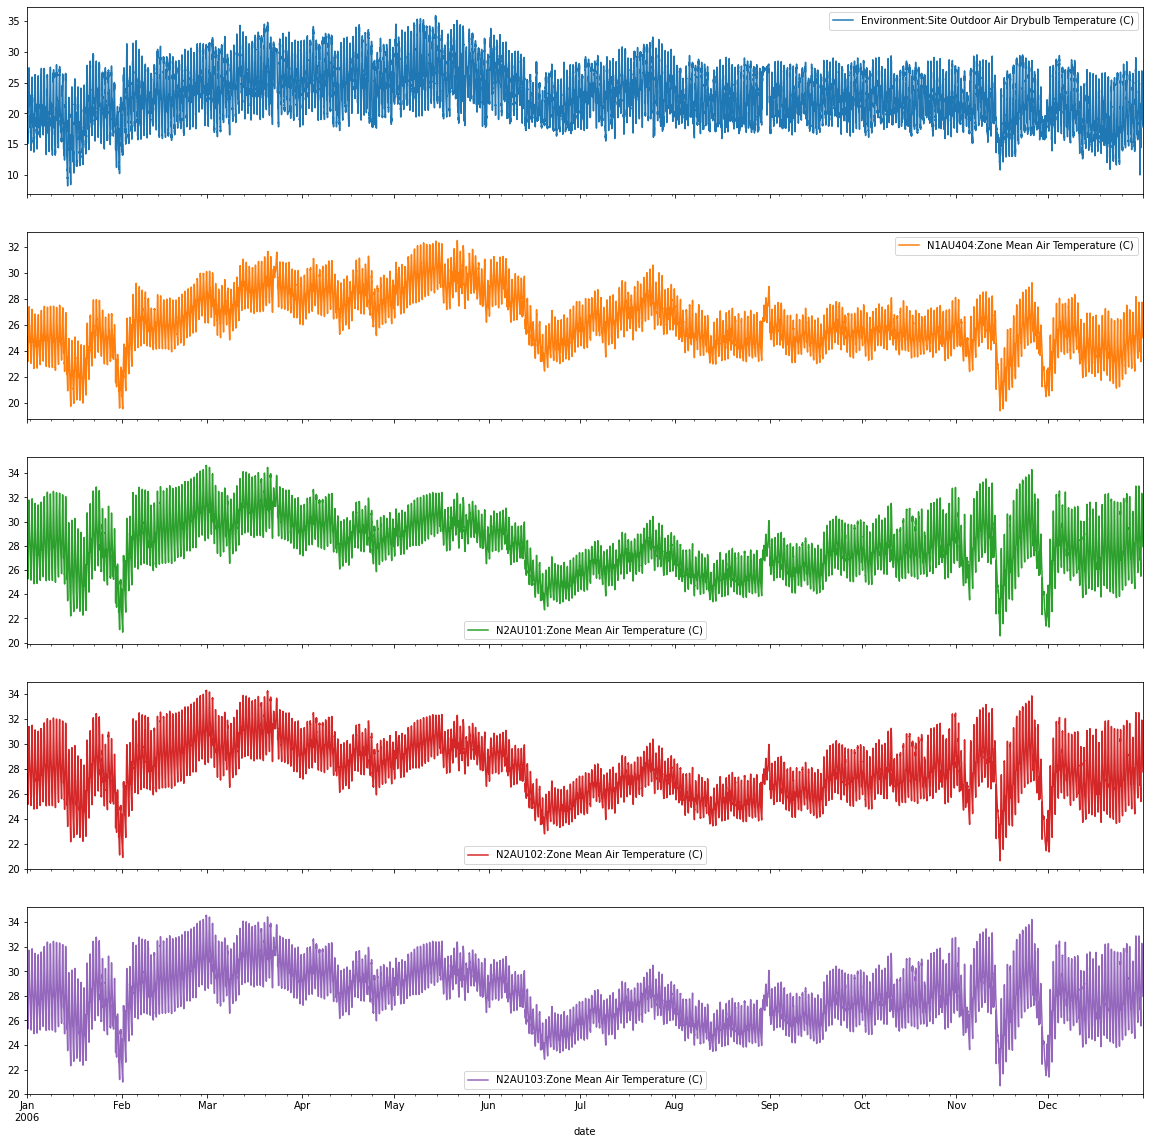

In [14]:
caso1.plot(subplots=True,figsize=(20,20));